In [14]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`


In [3]:
dd=IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");

In [4]:
using Statistics
function add_thickness(r,z,thikness)

    mr=Statistics.mean(r[1:end])
    dr=maximum(r)-minimum(r)
    mz=Statistics.mean(z[1:end])
    dz=maximum(z)-minimum(z)
    
    xr=thikness/dr
    xz=thikness/dz

    return @. (r-mr)*(1+xr)+mr,(z-mz)*(1+xz)+mz
end

rCSout=[0.7,7.3,7.3,0.7,0.7]
zCSout=[4.8,4.8,-4.8,-4.8,4.8]
rCSblanket,zCSblanket=add_thickness(rCSout,rCSout,-0.8)
rBlanket,zBlanket=add_thickness(rCSblanket,zCSblanket,-1.0)
rCryo=[0.0,10,10,0.0,0.0]
zCryo=[6,6,-6,-6,6];

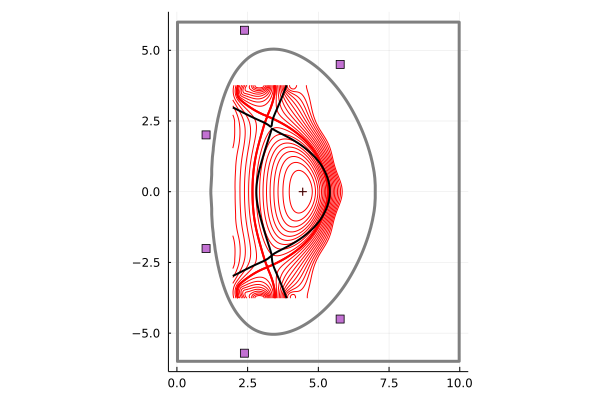

 * Status: success

 * Candidate solution
    Final objective value:     1.219066e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit 30)
    Iterations:    731
    f(x) calls:    1153



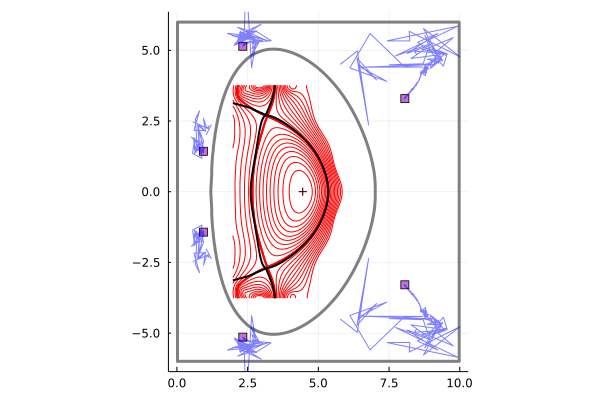

In [7]:
using Plots
#pfoptactor=PFcoilsOptActor(dd.equilibrium,0.006, 6, 1E-13, zip(rCSout,zCSout), zip(rCryo,zCryo));
pfoptactor=PFcoilsOptActor(dd.equilibrium,0.006, 6, 1E-13, 4. ,zip(rCryo,zCryo));

display(plot(pfoptactor))

step(pfoptactor,symmetric=true,λ_currents=1E8, verbose=true);

display(plot(pfoptactor));

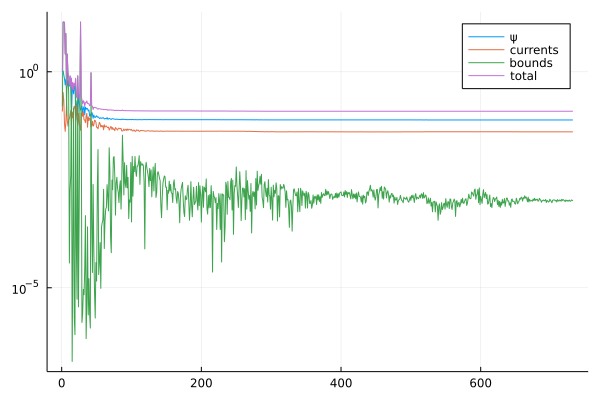

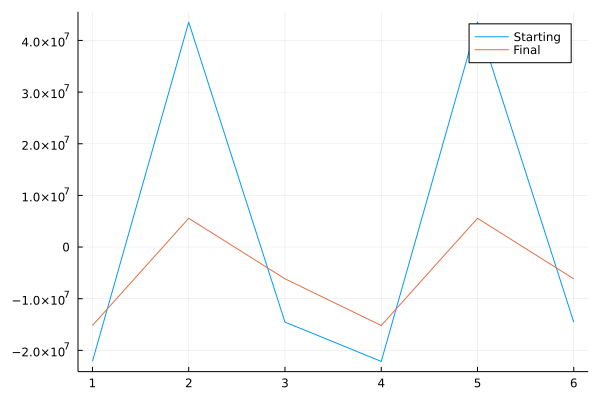

In [13]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.trace,:currents))